In [1]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
import sys
import os
sys.path.append(os.path.join('..', '..', '..' ))

from shared.cifar10_dvs_dataset import CIFAR10DVSData

data_handler = CIFAR10DVSData(save_to='../../../shared/datasets')
data_handler.check_and_download()

train_dataloader, val_dataloader, test_dataloader = data_handler.get_frame_dataloader(batch_size=128, train_ratio=0.7)

c:\Users\xsb24130\AppData\Local\miniconda3\envs\akida-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CIFAR10DVS Data handler initialized. Data will be saved to '../../../shared/datasets'
Download check complete.
Splited dataset into:
 - Training set: 7000 samples
 - Validation set: 1500 samples
 - Test set: 1500 samples


Shape of a frame-based data batch: torch.Size([128, 1, 32, 32])
Labels of the batch: tensor([3, 3, 3, 5, 3, 8, 3, 3, 1, 7, 7, 7, 8, 0, 6, 6, 5, 0, 8, 6, 0, 5, 7, 7,
        0, 6, 2, 0, 1, 1, 1, 1, 9, 9, 7, 2, 8, 8, 4, 8, 7, 1, 8, 8, 0, 3, 6, 3,
        9, 2, 9, 5, 4, 3, 3, 0, 7, 9, 3, 8, 6, 8, 7, 7, 6, 3, 1, 8, 6, 5, 0, 4,
        3, 4, 1, 0, 2, 1, 1, 6, 2, 0, 9, 9, 2, 5, 0, 7, 8, 9, 5, 6, 0, 8, 6, 2,
        9, 1, 9, 2, 4, 5, 3, 5, 4, 5, 2, 5, 0, 1, 6, 9, 7, 0, 6, 9, 0, 3, 9, 0,
        2, 6, 6, 4, 7, 0, 3, 4])


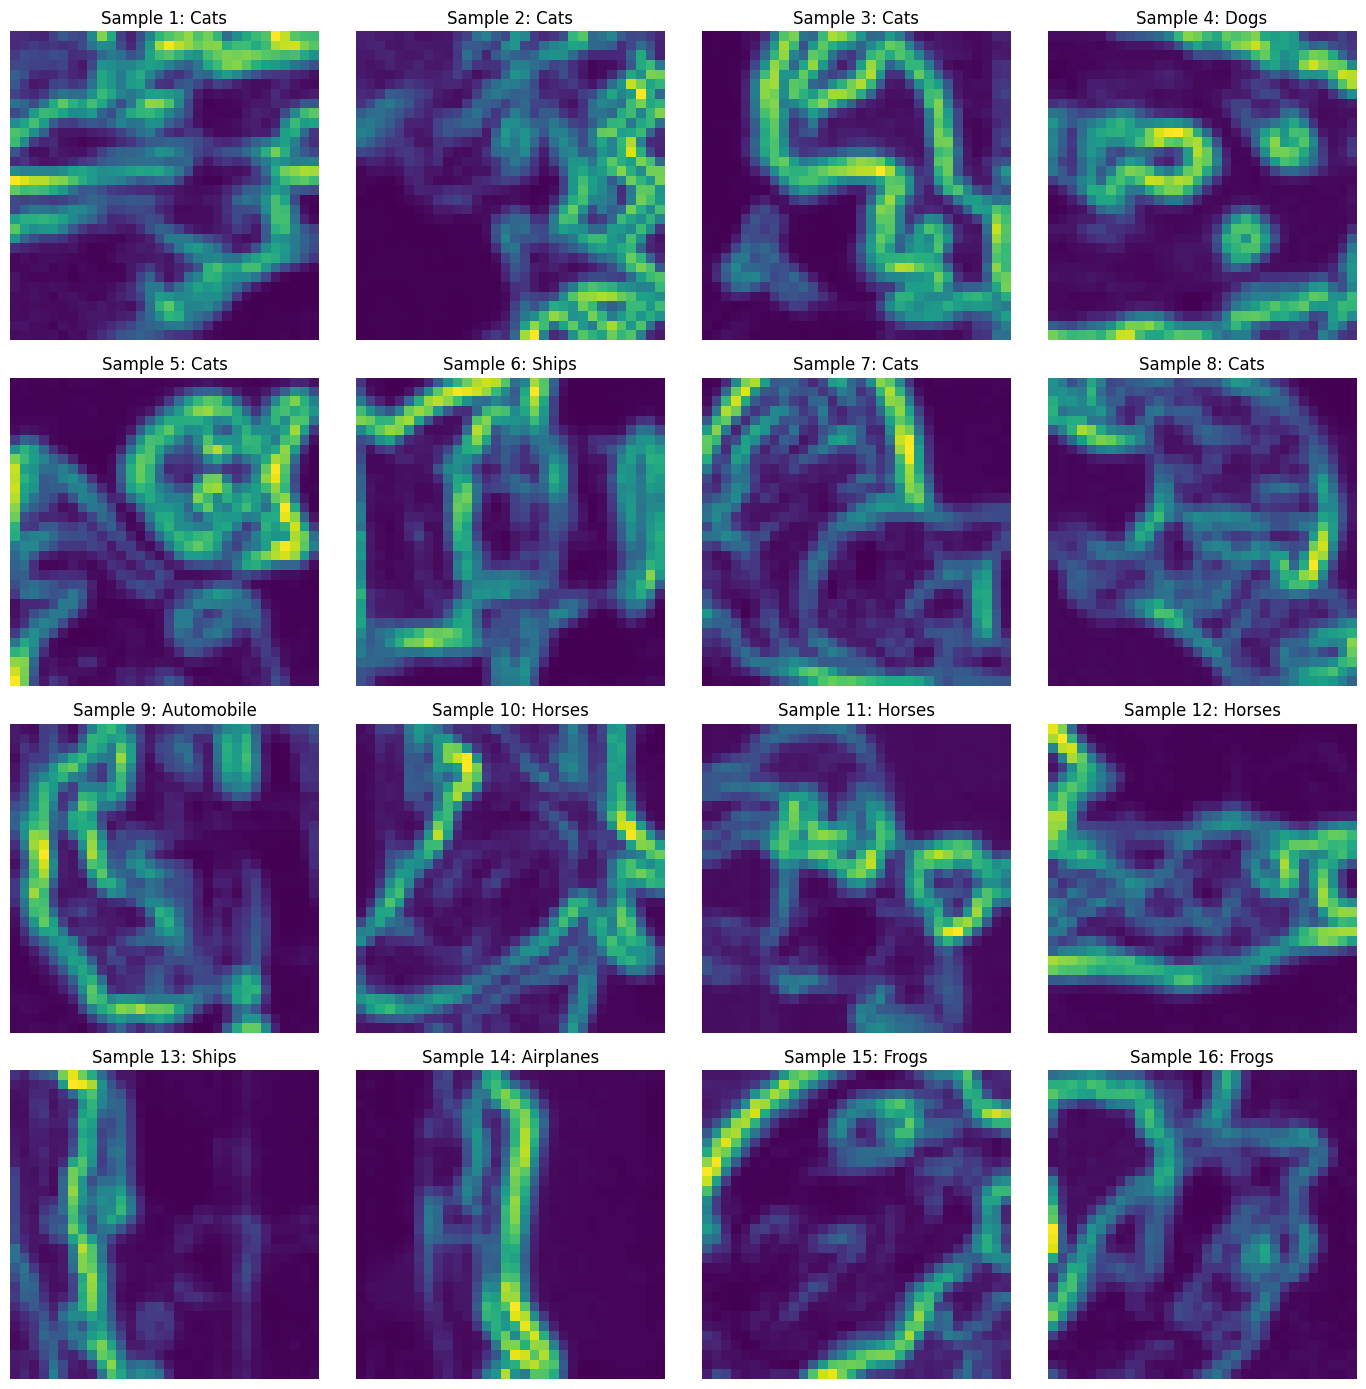

In [3]:
import matplotlib.pyplot as plt

# Get one batch from the train_dataloader
samples, labels = next(iter(train_dataloader))
print(f"Shape of a frame-based data batch: {samples.shape}")
print(f"Labels of the batch: {labels}")


batch_size = samples.shape[0]
fig, axes = plt.subplots(4, 4, figsize=(14, 14))  # For batch_size=16
axes = axes.flatten()

for i in range(16):
    sample_img = samples[i, 0]  # shape: [H, W]
    ax = axes[i]
    ax.imshow(sample_img)
    label_index = labels[i].item()
    label_name = data_handler.labels[label_index]
    ax.set_title(f"Sample {i+1}: {label_name}", fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [4]:
import torch.nn as nn

dense_net_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32 * 32, 512),
    nn.Linear(512, 512),
    nn.Linear(512, 10),
)

In [6]:
dense_net_model.to(device)
print(dense_net_model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=1024, out_features=512, bias=True)
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): Linear(in_features=512, out_features=10, bias=True)
)


In [7]:
total_params = sum(p.numel() for p in dense_net_model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 792586


In [8]:
from shared.early_stopping import EarlyStopping
from shared.system_monitor import SystemMonitor

monitor = SystemMonitor(sample_interval=1.0)

optimizer = torch.optim.Adam(dense_net_model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=3, delta=0.01)

In [10]:
from shared.pytorch_trainer import Trainer

trainer = Trainer(
    model=dense_net_model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    early_stopping=early_stopping,
)

In [11]:
monitor.start()

trainer.train(num_epochs=100, log_interval=10)

monitor.stop()

System monitor started.
Starting training...
Train Epoch: 1 [1152/7000 (16%)]	Loss: 2.080388
Train Epoch: 1 [2432/7000 (35%)]	Loss: 1.967679
Train Epoch: 1 [3712/7000 (53%)]	Loss: 2.119210
Train Epoch: 1 [4992/7000 (71%)]	Loss: 2.165214
Train Epoch: 1 [6272/7000 (89%)]	Loss: 1.959283
Epoch 1 Summary -> Train Loss: 2.0881, Val Loss: 2.0798

Train Epoch: 2 [1152/7000 (16%)]	Loss: 2.020575
Train Epoch: 2 [2432/7000 (35%)]	Loss: 1.940631
Train Epoch: 2 [3712/7000 (53%)]	Loss: 2.012308
Train Epoch: 2 [4992/7000 (71%)]	Loss: 1.992029
Train Epoch: 2 [6272/7000 (89%)]	Loss: 1.913544
Epoch 2 Summary -> Train Loss: 1.9755, Val Loss: 2.0056

Train Epoch: 3 [1152/7000 (16%)]	Loss: 2.043556
Train Epoch: 3 [2432/7000 (35%)]	Loss: 1.837651
Train Epoch: 3 [3712/7000 (53%)]	Loss: 1.883992
Train Epoch: 3 [4992/7000 (71%)]	Loss: 2.039742
Train Epoch: 3 [6272/7000 (89%)]	Loss: 1.866076
Epoch 3 Summary -> Train Loss: 1.9301, Val Loss: 2.0847

Train Epoch: 4 [1152/7000 (16%)]	Loss: 1.858460
Train Epoch: 4 [

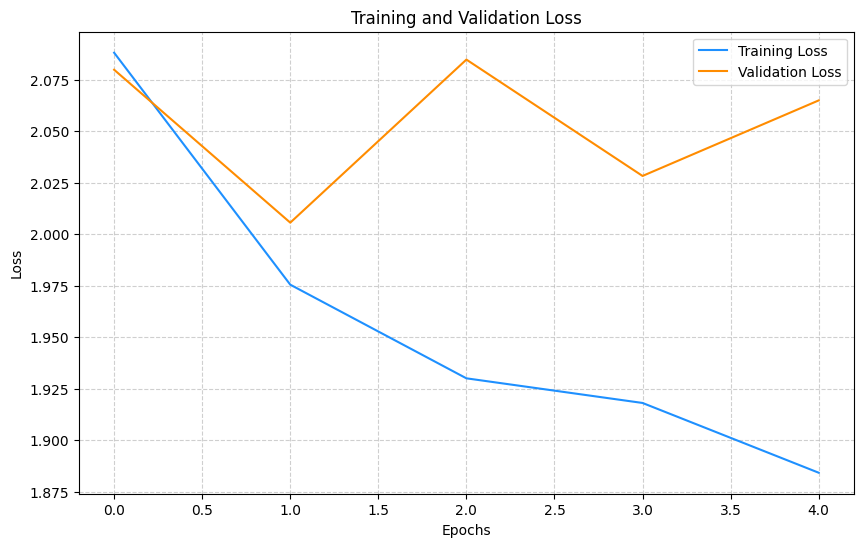

In [12]:
trainer.plot_learning_curve()


--- Test Set Evaluation ---
Average loss: 2.0446, Accuracy: 438/1500 (29.20%)

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.21      0.27       141
           1       0.30      0.52      0.38       144
           2       0.28      0.19      0.23       149
           3       0.21      0.09      0.13       152
           4       0.35      0.19      0.25       163
           5       0.25      0.32      0.28       155
           6       0.21      0.16      0.18       136
           7       0.30      0.53      0.38       153
           8       0.49      0.16      0.24       154
           9       0.28      0.55      0.37       153

    accuracy                           0.29      1500
   macro avg       0.31      0.29      0.27      1500
weighted avg       0.31      0.29      0.27      1500


Confusion Matrix:


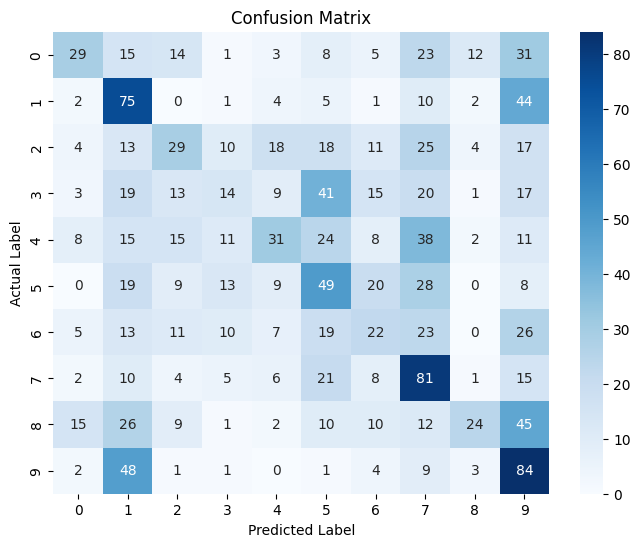

In [13]:
trainer.evaluate(test_dataloader)